## Prueba de concepto sobre segmentacion de abstracts con NLP
- 

#### Mapear los archivos

In [33]:
# import sys
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

from sklearn.feature_extraction.text import CountVectorizer

path = 'C:/Users/user/Desktop/Globant/T1/2020/'
# sys.path.append(path)

In [34]:
#TODO: Dar un comentario a cada funcion
def abstract_names_function(path):
    """
    Lista todos los nombres de los archivos en el directorio especificado.

    Args:
    path (str): La ruta al directorio del que se quieren listar los archivos.

    Returns:
    list: Una lista con los nombres de todos los archivos en el directorio.
    """
    # Verificar si el directorio existe
    if not os.path.exists(path):
        return "El directorio no existe."
    
    # Obtener todos los archivos y subdirectorios en el directorio especificado
    nombres_de_archivos = [archivo for archivo in os.listdir(path) if os.path.isfile(os.path.join(path, archivo))]

    return nombres_de_archivos

def abstract_sampler(full_list, n):
    """
    Selecciona una muestra aleatoria de n elementos de una lista de strings.

    Args:
    full_list (list): La lista original de strings de la cual seleccionar la muestra.
    n (int): El número de elementos a seleccionar.

    Returns:
    list: Una lista con n elementos seleccionados aleatoriamente de la lista original.
    """
    # Verificar si n es mayor que la longitud de la lista
    if n > len(full_list):
        return "Error: n es mayor que el número de elementos en la lista."
    
    # Seleccionar n elementos aleatorios de la lista
    muestra_seleccionada = random.sample(full_list, n)
    
    return muestra_seleccionada

def extract_data(file_path):
    """Función para extraer los datos relevantes de un archivo XML

    Args:
        file_path (arr): array con los nombres de los archivos en string

    Returns:
        _dict_: devuelve un diccionario con el titulo y el resumen del archivo
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extraer información básica
    title = root.find('.//AwardTitle').text if root.find('.//AwardTitle') is not None else "No Title"
    abstract = root.find('.//AbstractNarration').text if root.find('.//AbstractNarration') is not None else "No Abstract"
    
    return {
        "title": title,
        "abstract": abstract
    }

def clean_text(text): #TODO: Terminar documentacion
    """Función para limpiar el texto de los resúmenes

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    if pd.isna(text):
        return ""  # Retorna un string vacío si el texto es NaN

    # Eliminar etiquetas HTML
    text = re.sub(r'<[^>]+>', '', text)
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [35]:
# Ejemplo de uso:
archivos_full = abstract_names_function(path)
print(len(archivos_full))

13300


In [36]:
# Muestreo de la data
n = 9310 ## Cerca del 70% de los datos

muestra = abstract_sampler(archivos_full, n)

print("archivos: ", len(muestra))
print("array_view: ",muestra[:10])

archivos:  9310
array_view:  ['2031479.xml', '2004655.xml', '2004683.xml', '2030731.xml', '2001075.xml', '2016003.xml', '2033577.xml', '2001664.xml', '2007832.xml', '2021081.xml']


In [37]:
#muestra de testeo
set_orig = set(archivos_full)
set_sample = set(muestra)

set_test_sample = set_orig-set_sample
test_sample = list(set_test_sample)

print("archivos: ", len(test_sample))
print("array_view: ",test_sample[:10])

archivos:  3990
array_view:  ['2042203.xml', '2030568.xml', '2042596.xml', '2002879.xml', '2043535.xml', '2017826.xml', '2005574.xml', '2000748.xml', '2017106.xml', '2017122.xml']


In [38]:
path + muestra[0]

'C:/Users/user/Desktop/Globant/T1/2020/2031479.xml'

#### Ingestar la muestra

In [39]:
# Procesar cada archivo y almacenar los resultados en un DataFrame
data_list = [extract_data(path+file) for file in muestra]
df_abstracts = pd.DataFrame(data_list)

display(df_abstracts.head())

,title,abstract
0,Innovation Pathways to Data Careers,The use of big data as a decision-driver has e...
1,Understanding Domain Walls in a Two-Dimensiona...,Nontechnical Summary:<br/>In materials that co...
2,Collaborative Research: The Impact of Mesoscal...,This collaborative project studies intimate de...
3,Supporting the Success of Mechanical Engineeri...,This project will contribute to the national n...
4,SaTC: CORE: Medium: Collaborative: Rethinking ...,"When a program accesses data stored in memory,..."


In [40]:
# Aplicar la limpieza a los resúmenes
df_abstracts['clean_abstract'] = df_abstracts['abstract'].apply(clean_text)

display(df_abstracts.head())

#TODO: Documentar que limpiamos y por que

,title,abstract,clean_abstract
0,Innovation Pathways to Data Careers,The use of big data as a decision-driver has e...,the use of big data as a decisiondriver has ex...
1,Understanding Domain Walls in a Two-Dimensiona...,Nontechnical Summary:<br/>In materials that co...,nontechnical summaryin materials that contain ...
2,Collaborative Research: The Impact of Mesoscal...,This collaborative project studies intimate de...,this collaborative project studies intimate de...
3,Supporting the Success of Mechanical Engineeri...,This project will contribute to the national n...,this project will contribute to the national n...
4,SaTC: CORE: Medium: Collaborative: Rethinking ...,"When a program accesses data stored in memory,...",when a program accesses data stored in memory ...


#### EDA Simple

In [41]:
# custom_stop_words = [
#     'project', 'research', 'using', 'new', 'review','worthy',
#     'understanding', 'provide', 'use', 'work', 'study', 'used',
#     'including', 'methods'
# ]

# custom_stop_words = ['project','research']

In [42]:
# Configurando CountVectorizer para extraer las palabras más frecuentes
vectorizer = CountVectorizer(stop_words='english', max_features=50)
data_vectorized = vectorizer.fit_transform(df_abstracts['clean_abstract'])
frequent_words = vectorizer.get_feature_names_out()
# print(frequent_words)

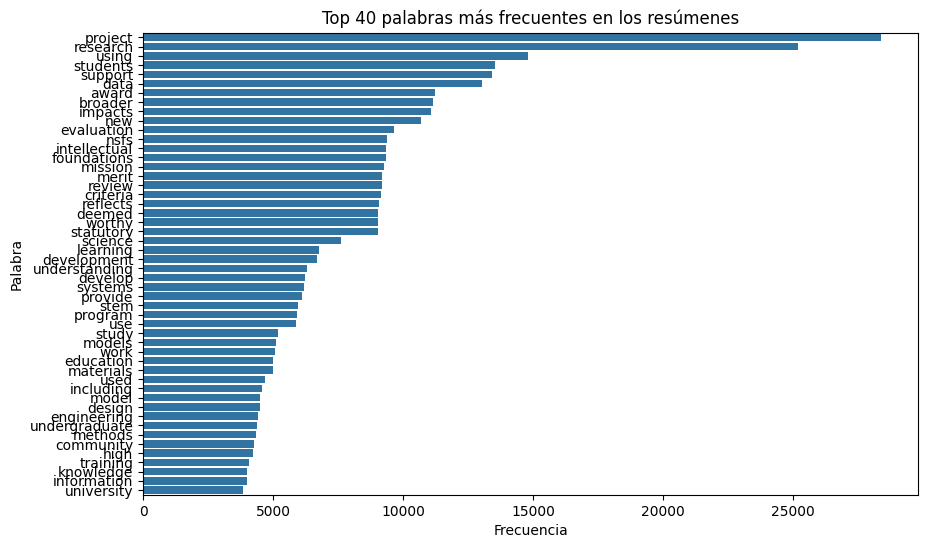

In [43]:
# Sumar las frecuencias de cada palabra
sum_words = data_vectorized.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Crear un DataFrame con las palabras más comunes
df_words = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Visualización de las palabras más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x='freq', y='word', data=df_words)
plt.title('Top 40 palabras más frecuentes en los resúmenes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

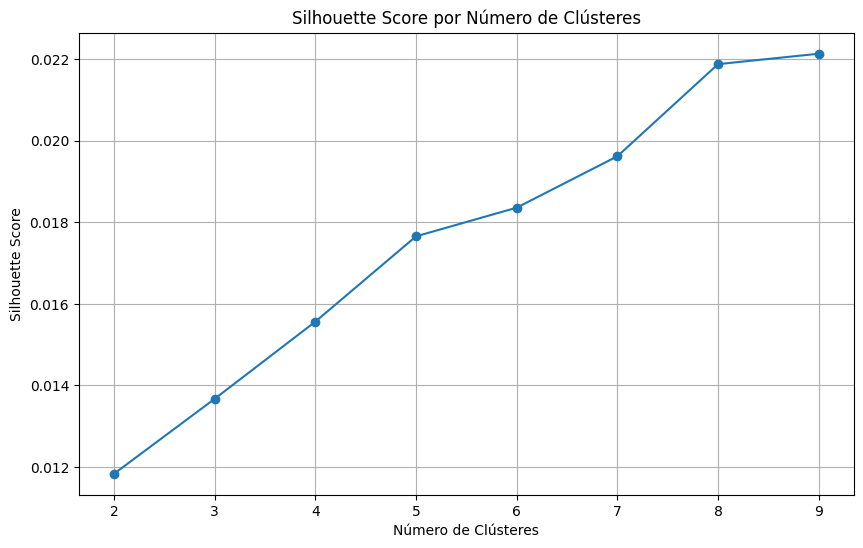

In [48]:
# Reducir el rango de número de clústeres y reintentar el cálculo de Silhouette Score
range_n_clusters = list(range(2, 10))  # Reducido de 11 a 10

# Calcular nuevamente el Silhouette Score para cada número de clústeres
silhouette_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(tfidf)
    silhouette_avg = silhouette_score(tfidf, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Gráfico del Silhouette Score por número de clústeres
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score por Número de Clústeres')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


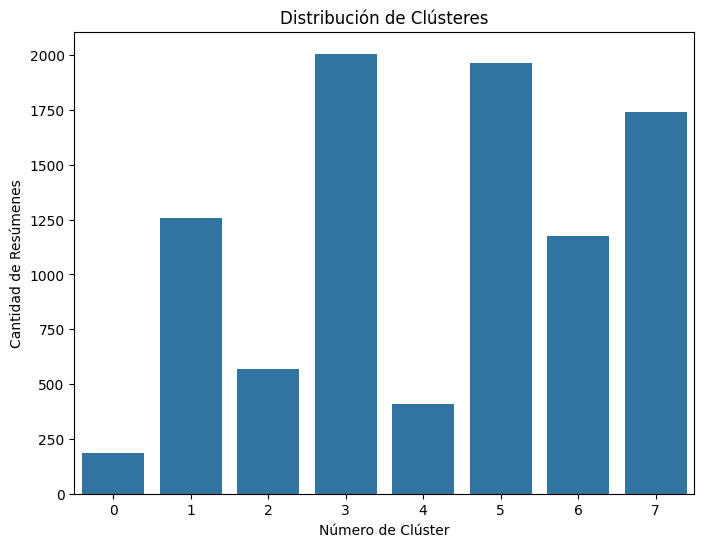

,title,cluster
0,Innovation Pathways to Data Careers,1
1,Understanding Domain Walls in a Two-Dimensiona...,3
2,Collaborative Research: The Impact of Mesoscal...,3
3,Supporting the Success of Mechanical Engineeri...,1
4,SaTC: CORE: Medium: Collaborative: Rethinking ...,7


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Configurar TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_abstracts['clean_abstract'])

# Configurar K-Means
k = 8  # Número de clústeres, puede ajustarse según sea necesario
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf)

# Asignar los clústeres a cada resumen
df_abstracts['cluster'] = kmeans.labels_

# Visualización de la distribución de clústeres
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df_abstracts)
plt.title('Distribución de Clústeres')
plt.xlabel('Número de Clúster')
plt.ylabel('Cantidad de Resúmenes')
plt.show()

df_abstracts[['title', 'cluster']].head()


In [50]:
from sklearn.metrics import silhouette_score

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(tfidf, kmeans.labels_)

# Extraer las palabras clave para cada clúster
def get_top_keywords(n_terms):
    df_clusters_keywords = pd.DataFrame()
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        center_terms = kmeans.cluster_centers_[i]
        sorted_terms = center_terms.argsort()[-n_terms:]
        df_clusters_keywords[f"Cluster {i}"] = terms[sorted_terms]
    return df_clusters_keywords

# Obtener las palabras clave de los clústeres
top_keywords = get_top_keywords(15)  # Muestra las 15 palabras clave más importantes por clúster

silhouette_avg, top_keywords


(0.02188162439851508,
       Cluster 0     Cluster 1         Cluster 2      Cluster 3     Cluster 4  \
 0       optical   mathematics       development           used       physics   
 1        states   development         treatment      chemistry  applications   
 2       science  professional            device      molecular        spaces   
 3    properties       student          research           high      research   
 4           new      teachers          patients  understanding   mathematics   
 5       devices   engineering         potential           cell         study   
 6      research       science  impactcommercial       chemical       project   
 7       project       faculty          proposed          cells            pi   
 8   topological      learning             small     properties     geometric   
 9   information       project        technology         energy      problems   
 10      systems       program           project       students     algebraic   
 11   

## Conclusión Preliminar

Se han identificado siete clústeres de abstracts de papers basados en las palabras más usadas. A continuación, se presenta una descripción breve de cada clúster:

### Cluster 0: Física y Óptica
- **Temática:** Física, óptica y propiedades topológicas.
- **Palabras Clave:** optical, states, science, properties, devices.

### Cluster 1: Educación y Desarrollo Profesional
- **Temática:** Educación, desarrollo profesional y ciencias.
- **Palabras Clave:** mathematics, development, professional, student, teachers.

### Cluster 2: Innovación y Desarrollo Tecnológico
- **Temática:** Innovación tecnológica y desarrollo de dispositivos.
- **Palabras Clave:** development, treatment, device, research, patients.

### Cluster 3: Química y Biología Molecular
- **Temática:** Química, biología molecular y ciencias de materiales.
- **Palabras Clave:** used, chemistry, molecular, high, understanding.

### Cluster 4: Matemáticas y Física Teórica <u>Entre el 0, el 2, el 3 y el 7 un poco difuso</u> <!--Esto hace mucho sentido, no?-->
- **Temática:** Matemáticas, física teórica y aplicaciones geométricas.
- **Palabras Clave:** physics, applications, spaces, research, mathematics.

### Cluster 5: Salud Pública y Enfermedades Infecciosas
- **Temática:** Salud pública y enfermedades infecciosas, como el COVID-19.
- **Palabras Clave:** new, sarscov, disease, risk, communities.

### Cluster 6: Ciencias Ambientales y del Clima
- **Temática:** Cambio climático, procesos ambientales y estudios del suelo.
- **Palabras Clave:** soil, change, sea, global, changes.

### Cluster 7: Redes y Tecnologías de la Información <u>El 2 y el 7 estan super pegados el uno y del otro</u> <!--Esto hace mucho sentido, no?-->
- **Temática:** Redes, diseño de métodos y aplicaciones de software.
- **Palabras Clave:** networks, design, methods, applications, models.

Estos clústeres reflejan áreas temáticas bien definidas, lo que facilita la categorización y comprensión de los enfoques principales en los abstracts de los papers.


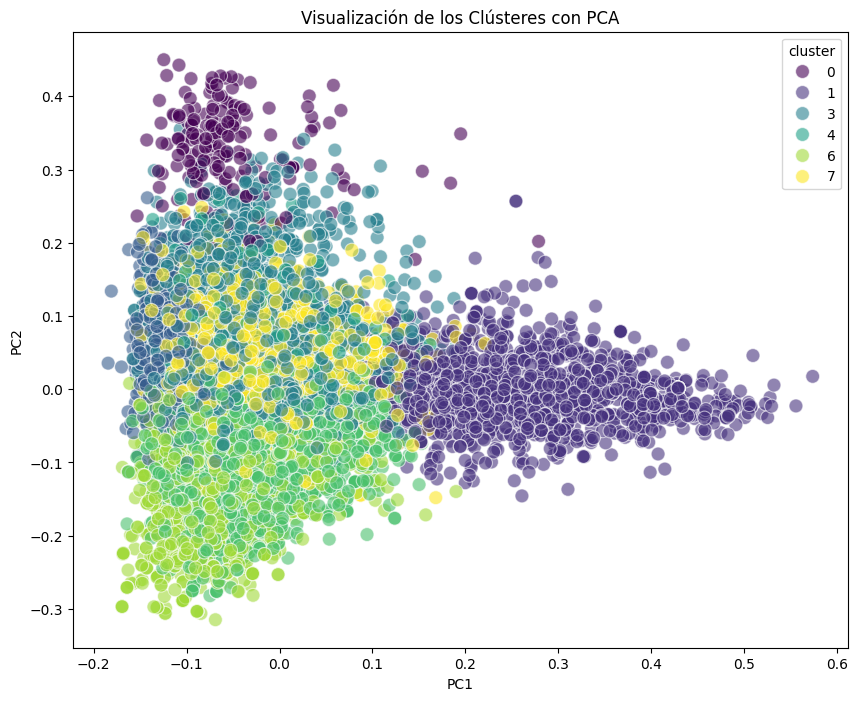

In [51]:
from sklearn.decomposition import PCA

# Reducir la dimensionalidad a 2D para la visualización
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf.toarray())

# Crear un DataFrame para la visualización
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
df_viz['cluster'] = kmeans.labels_

# Gráfico de dispersión de los clústeres
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_viz, s=100, alpha=0.6)
plt.title('Visualización de los Clústeres con PCA')
plt.show()


In [52]:
#G2
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# Supongo que 'tfidf' es tu matriz de características tf-idf y 'kmeans' es tu modelo KMeans
# Reducir la dimensionalidad a 3D para la visualización
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(tfidf.toarray())

# Crear un DataFrame para la visualización
df_viz = pd.DataFrame(reduced_features, columns=['PC1', 'PC2', 'PC3'])
df_viz['cluster'] = kmeans.labels_

# Obtener el número de puntos en cada cluster
cluster_counts = df_viz['cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Fusionar cluster_counts con df_viz
df_viz = pd.merge(df_viz, cluster_counts, on='cluster')

# Gráfico de dispersión de los clústeres en 3D usando Plotly
fig = px.scatter_3d(df_viz, x='PC1', y='PC2', z='PC3', color='cluster', 
                    title='Visualización de los Clústeres con PCA en 3D',
                    labels={'PC1': 'Componente Principal 1', 
                            'PC2': 'Componente Principal 2', 
                            'PC3': 'Componente Principal 3'},
                    hover_data={'cluster': True, 'count': True},
                    color_continuous_scale=px.colors.qualitative.Set1)

# Personalizar leyenda
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))

# Agregar título y etiquetas
fig.update_layout(scene=dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                  margin=dict(l=0, r=0, b=0, t=40),
                  legend_title='Cluster')

# Mostrar el gráfico interactivo
fig.show()